In [2]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

In [6]:
df_utility = pd.read_excel("./Exports/TeamExport_A46051_Alpha_M_Period 2.xlsx", 
                          sheet_name="Studies - Sonites Market",
                          usecols="E:M",
                          skiprows=570)


df_utility

,Segment,Design_Level,Design_Utility,Display_Level,Display_Utility,Proc. Power_Level,Proc. Power_Utility,Price_Level,Price_Utility
0,Explorers,3,0.459,22,0.362,52,0.047,196,0.187
1,Explorers,4,0.514,28,0.485,68,0.448,275,1.000
2,Explorers,5,0.521,34,0.564,84,0.748,354,0.828
3,Explorers,6,0.521,40,0.603,100,0.771,433,0.000
4,Shoppers,7,0.550,15,0.547,33,0.407,155,0.292
5,Shoppers,8,0.553,21,0.561,49,0.709,234,0.902
6,Shoppers,9,0.550,27,0.565,65,0.696,313,1.000
7,Shoppers,10,0.541,33,0.521,81,0.383,392,0.000
8,Professionals,7,0.329,22,0.411,52,0.179,301,0.000
9,Professionals,8,0.435,28,0.417,68,0.557,380,1.000


In [7]:
sectors = list(df_utility["Segment"].unique())
sectors

cols_to_interpolate = [col for col in df_utility.columns if col.endswith("Level")]
cols_to_interpolate

x_values = {}

for col in cols_to_interpolate:
    x_list = list(df_utility[col].unique())
    x_list.sort()  # Sort in place
    x_values[col] = x_list  # Assign the sorted list

print(x_values)

{'Design_Level': [3, 4, 5, 6, 7, 8, 9, 10], 'Display_Level': [6, 12, 15, 18, 21, 22, 24, 27, 28, 33, 34, 40], 'Proc. Power_Level': [5, 21, 33, 37, 42, 49, 52, 53, 58, 65, 68, 74, 81, 84, 90, 100], 'Price_Level': [100, 155, 179, 196, 234, 258, 275, 301, 313, 327, 337, 354, 380, 392, 406, 433, 459, 485, 538, 564]}


In [10]:
# ["Design", "Display", "Proc. Power", "Price"]
feature = "Price"
level = f'{feature}_Level'
util = f'{feature}_Utility'

# Get unique sectors
sectors = df_utility["Segment"].unique()
x_new = x_values[level]

# Initialize a DataFrame with x_new as the index
result_df = pd.DataFrame(x_new, columns=[level])

# Perform interpolation for each sector and add the results to the DataFrame
for sector in sectors:
    # Filter the data for the current sector
    x_base = df_utility[df_utility["Segment"] == sector][level].values
    y_base = df_utility[df_utility["Segment"] == sector][util].values

    # Create the spline and interpolate
    spline = UnivariateSpline(x_base, y_base, k=3, s=0)
    y_interp = spline(x_new)
    y_interp = np.clip(y_interp, a_min=0, a_max=1)

    # Add the interpolated y values as a new column in result_df
    result_df[sector] = y_interp

# Example weights dictionary for each sector
weights = {
    "Explorers": 0.2,
    "Shoppers": 0.2,
    "Professionals": 0.2,
    "High Earners": 0.2,
    "Savers": 0.2
}

# Ensure weights add up to 1
assert np.isclose(sum(weights.values()), 1), "Weights must sum to 1."

# Compute the weighted average by multiplying each sector's column by its weight
result_df["Weighted_Average"] = sum(result_df[sector] * weight for sector, weight in weights.items())


result_df



,Price_Level,Explorers,Shoppers,Professionals,High Earners,Savers,Weighted_Average
0,100,0.000000,0.000000,0.000000,0.000000,0.958000,0.191600
1,155,0.000000,0.292000,0.000000,0.000000,0.980543,0.254509
2,179,0.000000,0.496423,0.000000,0.000000,1.000000,0.299285
3,196,0.187000,0.636381,0.000000,0.000000,1.000000,0.364676
4,234,0.721803,0.902000,0.000000,0.000000,0.957796,0.516320
5,258,0.919479,1.000000,0.000000,0.000000,0.865000,0.556896
6,275,1.000000,1.000000,0.000000,0.000000,0.759418,0.551884
7,301,1.000000,1.000000,0.000000,0.000000,0.520015,0.504003
8,313,1.000000,1.000000,0.322385,0.000000,0.373049,0.539087
9,327,0.977124,0.919599,0.609610,0.000000,0.168938,0.535054


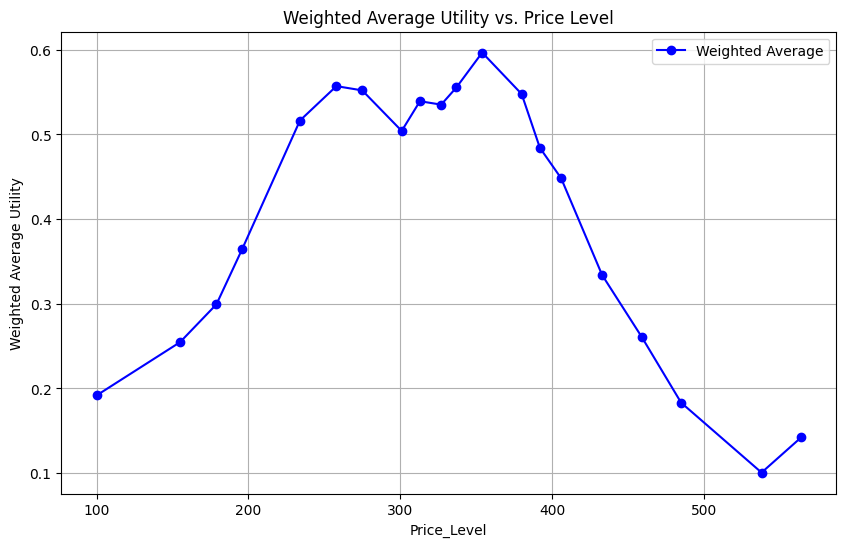

In [11]:


# Plot the weighted average against x_new
plt.figure(figsize=(10, 6))
plt.plot(result_df[level], result_df["Weighted_Average"], label="Weighted Average", color="b", marker="o")

# Add labels and title
plt.xlabel(level)
plt.ylabel("Weighted Average Utility")
plt.title(f"Weighted Average Utility vs. {feature} Level")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [8]:
df_semantic_ideal = pd.read_excel("./TeamExport_A46051_Alpha_M_Period 1.xlsx", 
                          sheet_name="Studies - Sonites Market",
                          usecols="D:K",
                          skiprows=255)

df_semantic_ideal = df_semantic_ideal.iloc[:32]
df_semantic_ideal = df_semantic_ideal.dropna()
df_semantic_ideal[df_semantic_ideal["Period"]==1].values.shape[0]

5

In [9]:

df_centroid = df_semantic_ideal[df_semantic_ideal["Period"]==1]
df_centroid = df_centroid.drop(["Segment"], axis=1)

print(df_centroid)

data_points = df_centroid.values
weights = np.array([0.6, 0.2, 0.2, 0, 0])

weighted_centroid = np.sum(data_points.T * weights, axis=1) / np.sum(weights)
weighted_centroid

  Period # Features Design Index Battery Life Display Size Proc. Power Price
0      1       4.65          1.8         6.03         5.99        6.25  3.54
1      1       3.27         6.38         3.57         4.64        4.83  5.59
2      1       5.56         5.85         5.05         5.46        5.28     5
3      1       2.53         3.89         1.75         2.58        2.22  2.14
4      1       1.81         5.08         2.93         4.13        3.86  3.14


array([1.0, 4.556, 3.526, 5.342, 5.614000000000001, 5.772, 4.242],
      dtype=object)

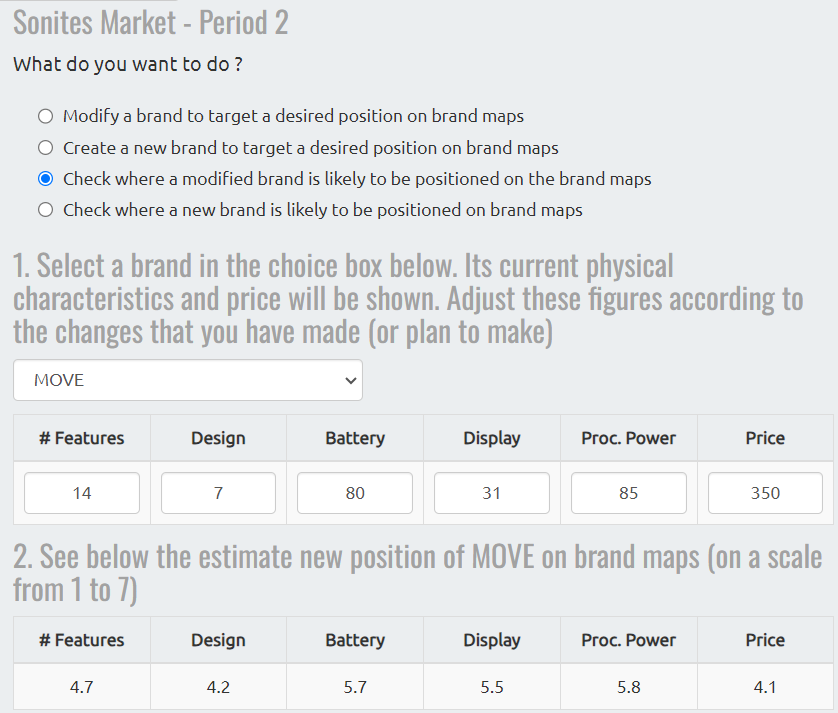

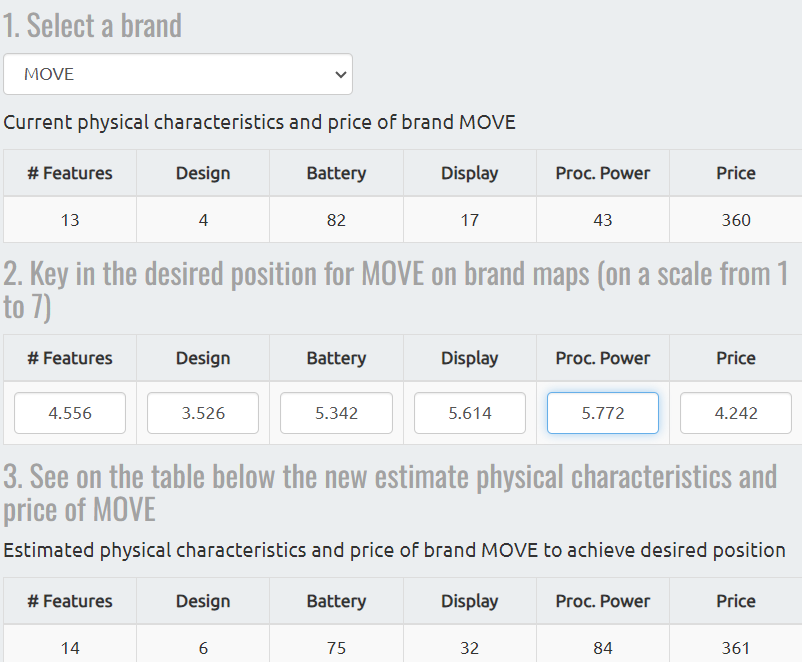

In [10]:
df_mds_ideal = pd.read_excel("./TeamExport_A46051_Alpha_M_Period 1.xlsx", 
                          sheet_name="Studies - Sonites Market",
                          usecols="D:H",
                          skiprows=328)

df_mds_ideal = df_mds_ideal.iloc[:30]
df_mds_ideal = df_mds_ideal.dropna()
df_mds_ideal = df_mds_ideal[df_mds_ideal["Period"]==1]
df_mds_ideal

,Segment,Period,Economy,Performance,Convenience
0,Explorers,1,3.06,14.48,-7.14
1,High Earners,1,-10.62,5.16,10.04
2,Professionals,1,-6.64,8.9,11.1
3,Savers,1,12.38,-11.12,-4.48
4,Shoppers,1,5.72,-0.38,2.16


In [11]:
df_centroid = df_mds_ideal.drop(["Segment", "Period"], axis=1)

data_points = df_centroid.values
weights = np.array([0.6, 0.2, 0.2, 0, 0])

weighted_centroid = np.sum(data_points.T * weights, axis=1) / np.sum(weights)
weighted_centroid

array([-1.6160000000000003, 11.5, -0.055999999999999606], dtype=object)

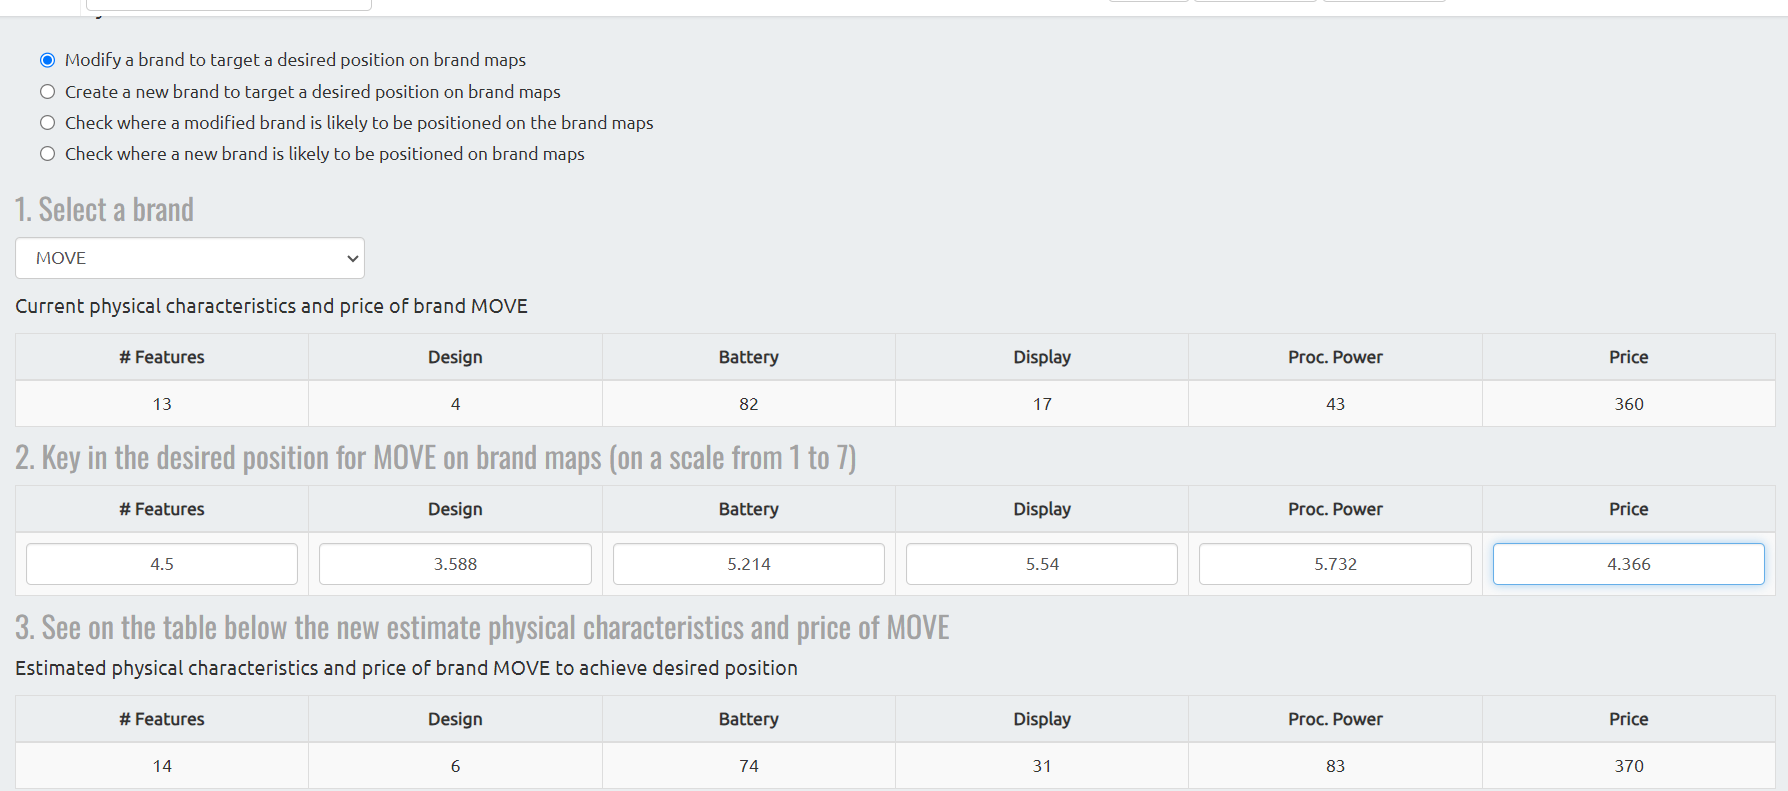

[4.452 3.588 5.214 5.54 5.732 4.3660000000000005]
[0.04938271604938271 0.11111111111111112 0.06172839506172839
 0.12757201646090535 0.23868312757201646 0.411522633744856]
Current features:
[[ 13.   4.  82.  17.  43. 360.]]

Predicted features:
[14, 6, 74, 31, 83, 370]

Absolute Manhattan distance:
[[ 1.  2.  8. 14. 40. 10.]]

Relative Manhattan distance:
[[0.07692308 0.5        0.09756098 0.82352941 0.93023256 0.02777778]]

Weighted average distance:
0.40389781675637837
